In [1]:
import csv
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import os
import random

from collections import defaultdict
from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NormalPredictor, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline, dump
from surprise.model_selection import cross_validate, train_test_split 

# Test various models for our recommendation system

## Test on sample data

Make sure surprise is working

In [2]:
data = Dataset.load_builtin('ml-100k')
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9269  0.9361  0.9387  0.9388  0.9378  0.9356  0.0045  
MAE (testset)     0.7322  0.7379  0.7395  0.7379  0.7396  0.7374  0.0027  
FCP (testset)     0.7008  0.7090  0.6927  0.6943  0.6978  0.6989  0.0058  
Fit time          0.80    0.80    0.82    0.80    0.85    0.82    0.02    
Test time         0.13    0.17    0.17    0.13    0.17    0.15    0.02    


{'test_rmse': array([0.92687412, 0.93606738, 0.93868011, 0.93875038, 0.93781348]),
 'test_mae': array([0.73224607, 0.73790002, 0.73953471, 0.73790952, 0.73962704]),
 'test_fcp': array([0.70083318, 0.70902896, 0.69274535, 0.69425765, 0.69781966]),
 'fit_time': (0.8011260032653809,
  0.8025648593902588,
  0.8191921710968018,
  0.8045997619628906,
  0.847977876663208),
 'test_time': (0.13108301162719727,
  0.17012310028076172,
  0.1702570915222168,
  0.1306447982788086,
  0.16532683372497559)}

## Test KNNWithMeans settings

Test RMSE and MAE values against similarity metrics and against user-user vs. item-item comparisions. Cosine was not tested since it faced issues with the 0 values in the dataset.

In [3]:
all_champs = os.path.expanduser('../data/surprise_data_full.csv')
users_750 = os.path.expanduser('../data/surprise_data_750.csv')

file_path = users_750
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

In [ ]:
options = ['pearson_baseline', 'MSD', 'pearson']
value = [True, False]

results = {}
for opt in options:
    for val in value:            
        sim_options = {
            "name": opt,
            "user_based": val
        }

        algo = KNNWithMeans(sim_options=sim_options)
        res = cross_validate(algo, data, measures=['RMSE', 'MAE', 'FCP'], cv=3, verbose=False)

        if val:
            entry = opt + " (T)"
        else:
            entry = opt + " (F)"

        results[entry] = {"RMSE": res['test_rmse'].mean(), "MAE": res['test_mae'].mean(), 'FCP': res['test_fcp'].mean(), 'Test Time': res['test_time'][-1]}

User Based comparision took 3x longer than Item based similarity comparision. FCP seems to be maximized and RMSE/MAE seems to be minimized when using pearson_baseline.

In [5]:
pprint.pprint(results)

{'MSD (F)': {'FCP': 0.6624841662135398,
             'MAE': 0.05977096656182945,
             'RMSE': 0.12074413775865696,
             'Test Time': 6.120896100997925},
 'MSD (T)': {'FCP': 0.644606311236349,
             'MAE': 0.06261393404456854,
             'RMSE': 0.12032552701217554,
             'Test Time': 18.25139832496643},
 'pearson (F)': {'FCP': 0.6748867740613481,
                 'MAE': 0.05583031313124506,
                 'RMSE': 0.11706185636355182,
                 'Test Time': 5.729834079742432},
 'pearson (T)': {'FCP': 0.661433571260926,
                 'MAE': 0.056293001953126094,
                 'RMSE': 0.11691082874104085,
                 'Test Time': 17.186127185821533},
 'pearson_baseline (F)': {'FCP': 0.6794465079962381,
                          'MAE': 0.05412229796083945,
                          'RMSE': 0.11562225802796738,
                          'Test Time': 5.634160757064819},
 'pearson_baseline (T)': {'FCP': 0.6698827025977927,
                  

In [6]:
x = np.arange(5, 60, 5)
y = np.zeros_like(x, dtype=float)

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

for i, n in enumerate(x):
    algo = KNNWithMeans(k=n, sim_options=sim_options)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Text(0.5, 0, 'k neighbors')

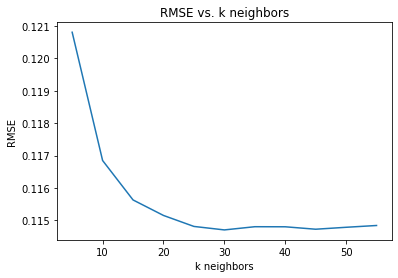

In [7]:
plt.plot(x,y)
plt.title("RMSE vs. k neighbors")
plt.ylabel("RMSE")
plt.xlabel("k neighbors")

# 25 seems to be where the dropoff stops

## Test effect of N Factors on RMSE for N Factors in SVD

In [8]:
x = np.arange(2, 161, 5)
y = np.zeros_like(x, dtype=float)
for i, n in enumerate(x):
    algo = SVD(n_factors=n)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112
117
122
127
132
137
142
147
152
157


Text(0.5, 0, 'N factors')

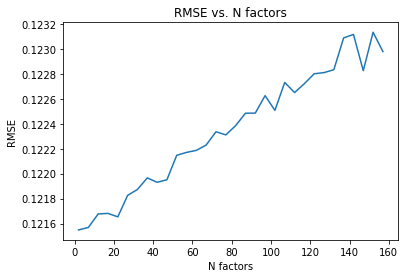

In [9]:
plt.plot(x,y)
plt.title("RMSE vs. N factors")
plt.ylabel("RMSE")
plt.xlabel("N factors")

# RMSE increases slightly with N factors, however at the lowest level it still gets outperformed by kNN

## Test available classifiers on champion data

SVD - predict a user's rating of a given champion, accounting for their individual bias.

SVD++ - extension of SVD, accounting for implicit ratings, which accounts for the fact that a user rated item j without accouting for the given value (the user looked at this value)

Baseline - predicts baseline estimate for given user and item

Random - give a random rating based on distribution of training set

NMF - based on Non-negative Matrix Factorization, similar to SVD - algorithm highly dependent on initial values

Slope One - predict users preference for particular item based on preferences of other users

Co-clustering - users and items assigned clusters

k-NN Basic - aggregate of neighbors

Centered k-NN - aggregate of neighbors, but the mean rating of each user is accounted for

k-NN baseline - k-nn, but a baseline rating is accounted for

In [10]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

k = 25
classifiers = [BaselineOnly(), SVD(), SVDpp(), NormalPredictor(), NMF(), \
               SlopeOne(), CoClustering(n_cltr_u = 3, n_cltr_i = 3), KNNBasic(k=k, sim_options=sim_options), \
               KNNWithMeans(k=k, sim_options=sim_options), KNNBaseline(k=k, sim_options=sim_options)]

labels = ['Baseline', 'SVD', 'SVDpp', 'Random', 'NMF', 'Slope One', 'Co-clustering', 'KNN', 'KNN With Means','KNN Baseline']

results = {}
for (cls, tag) in zip(classifiers, labels):
    print(tag)
    res = cross_validate(cls, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=False)
    results[tag] = results[entry] = {"RMSE": res['test_rmse'].mean(), "MAE": res['test_mae'].mean(), 'FCP': res['test_fcp'].mean(), 'Test Time': res['test_time'][-1]}

Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
SVD
SVDpp
Random
NMF
Slope One
Co-clustering
KNN
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
KNN With Means
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similari

### Analysis

KNN outperforms the other algorithms by every metric, with KNN With Means and KNNBaseline performing the best out of the KNN algorithms. NMF, Baseline, and SVD/SVDpp, SlopeOne seem to be a tier below kNN.

In [11]:
pprint.pprint(results)

{'Baseline': {'FCP': 0.6504430447834079,
              'MAE': 0.059197717615500745,
              'RMSE': 0.12147057421538861,
              'Test Time': 0.09508299827575684},
 'Co-clustering': {'FCP': 0.4563541982479576,
                   'MAE': 0.0536968552884455,
                   'RMSE': 0.13851173890375196,
                   'Test Time': 0.11064982414245605},
 'KNN': {'FCP': 0.6787553158710057,
         'MAE': 0.053658270144609756,
         'RMSE': 0.11663027614015394,
         'Test Time': 3.2376558780670166},
 'KNN Baseline': {'FCP': 0.6814396250614774,
                  'MAE': 0.05341711493884475,
                  'RMSE': 0.11494257270935786,
                  'Test Time': 3.635308027267456},
 'KNN With Means': {'FCP': 0.6807258011126373,
                    'MAE': 0.05344960405968406,
                    'RMSE': 0.11480651942325248,
                    'Test Time': 3.136636972427368},
 'NMF': {'FCP': 0.656728708763032,
         'MAE': 0.049622701149402496,
         'RMSE':

## Load in Champion Info

In [12]:
filename = '../data/champion.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)

champion_list = []
for i, c in enumerate(champ_data['data'].keys()):
    champion_list.append(champ_data['data'][c]['id'])

## Load in User's 5 Most played champs

This is so we don't recommend them later.

In [13]:
file_path = all_champs
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

In [14]:
most_played = {}

with open(file_path, 'r') as f:
    reader_obj = csv.reader(f)
    cur_id = ''
    most = []
    for row in reader_obj: 
        user_id, champion, score = row
        if cur_id != user_id:
            if cur_id != '':
                most_played[cur_id] = most
                most = []
            cur_id = user_id
        
        most.append(champion)

## Train kNN model on full dataset to test recommendation interface

In [15]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

trainset = data.build_full_trainset()
algo = KNNWithMeans(sim_options=sim_options)

algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Predictions are the same


### Get Mean Rating of each champion

In [16]:
mean_rating = {}

for rating in trainset.all_ratings():
    __, iid, rate = rating
    iid = trainset.to_raw_iid(iid)
    if iid not in mean_rating.keys():
        mean_rating[iid] = {'score': rate, 'n': 1, 'mean': rate}
    else:
        mean_rating[iid]['score'] += rate
        mean_rating[iid]['n'] += 1
        mean_rating[iid]['mean'] = mean_rating[iid]['score']/mean_rating[iid]['n']

In [17]:
def get_top_n(uid, champion_list):
    top_n = defaultdict(list)
    for champ in champion_list:
        top_n[uid].append((champ,algo.predict(uid, champ).est))
        #top_n[uid].append((champ,algo.predict(uid, champ).est/mean_rating[iid]['mean']))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings

    return top_n[uid]

def recommendChampion(uid, champs_played, champion_list, algo, n=10, ignore=5):
    print(f'User ID: {uid}')
    print(f'Champs Played: {champs_played[:ignore]}')
    print(f'Recommendations for {uid}')
    count = 0
    for rec in get_top_n(uid, champion_list):
        if count >= 5:
            break
        if rec[0] not in champs_played[:ignore]:
            print(count+1, rec[0])
            count += 1


In [18]:
test_IDS = []

for i in range(2):
    test_IDS.append(random.choice(list(most_played.keys())))
    
for i in test_IDS:
    recommendChampion(i, most_played[i], champion_list, algo, n=5, ignore=10)

User ID: vCFDFYQHJ6ytN58rp71ZuDSUIrOFA7L-cT3g-oGPKDlHbw8h
Champs Played: ['Lulu', 'Soraka', 'Seraphine', 'Karma', 'Lux', 'Leona', 'Ahri', 'Janna', 'Sona', 'Zyra']
Recommendations for vCFDFYQHJ6ytN58rp71ZuDSUIrOFA7L-cT3g-oGPKDlHbw8h
1 Yuumi
2 Nami
3 Morgana
4 Neeko
5 Annie
User ID: lmcVztny5xFQJoC6TKNXgKDTYl7M3Vpqvl-fqPZVHi2qibM0
Champs Played: ['Ahri', 'Ashe', 'Kaisa', 'Xayah', 'Lux', 'Jinx', 'Neeko', 'Morgana', 'Diana', 'Zed']
Recommendations for lmcVztny5xFQJoC6TKNXgKDTYl7M3Vpqvl-fqPZVHi2qibM0
1 Caitlyn
2 Ezreal
3 MissFortune
4 Jhin
5 Vayne
